We are going to break down the pipeline API from Hugging Face:

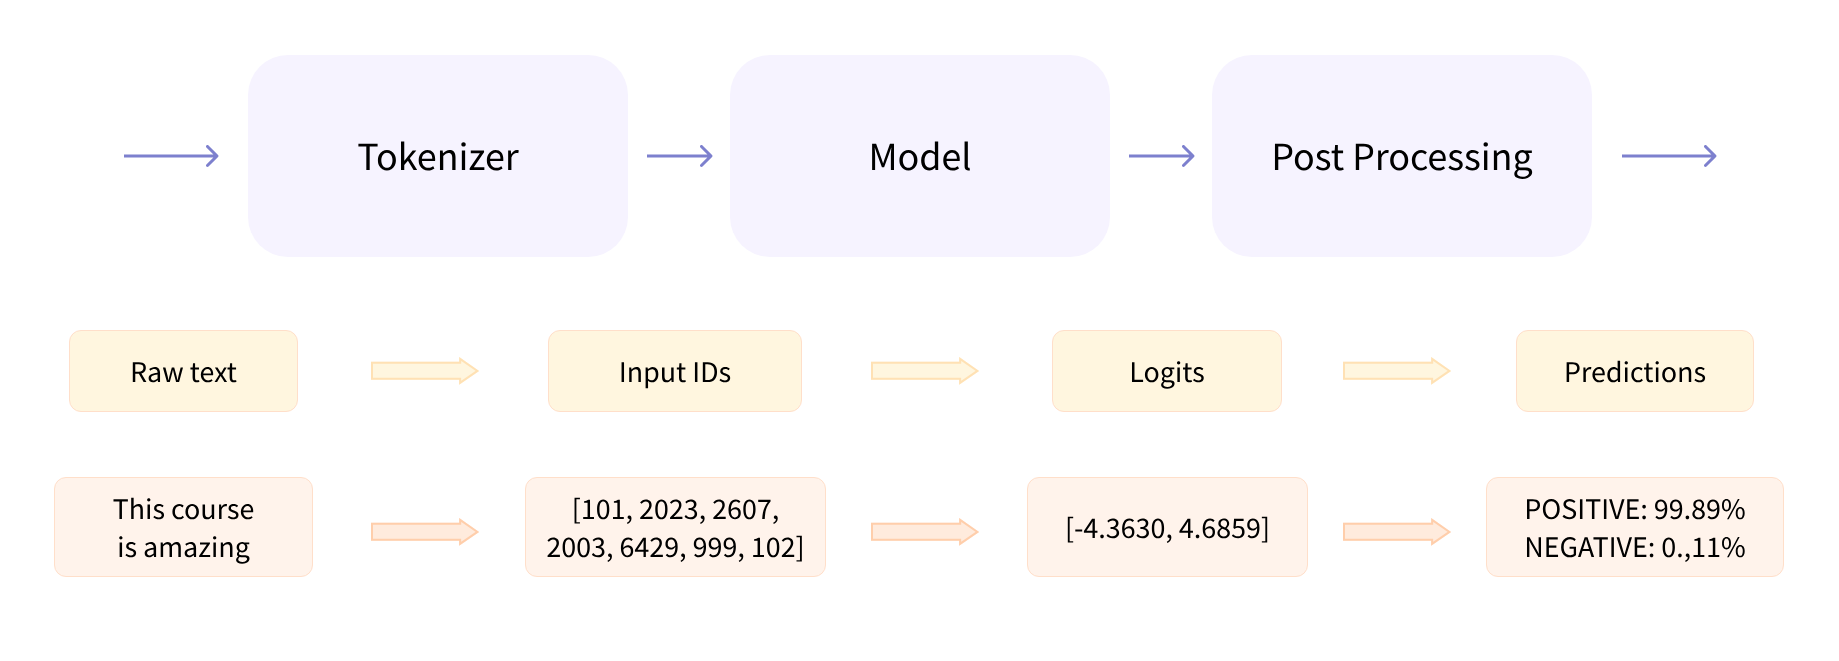

# Preprocessing with a tokenizer

Like other neural networks, Transformer models can’t process raw text directly, so the first step of our pipeline is to convert the text inputs into numbers that the model can make sense of. To do this we use a `tokenizer`, which will be responsible for:

- Splitting the input into words, subwords, or symbols (like punctuation) that are called tokens
- Mapping each token to an integer
- Adding additional inputs that may be useful to the model

All this preprocessing needs to be done in exactly the same way as when the model was pretrained, so we first need to download that information from the [Model Hub](https://huggingface.co/models). To do this, we use the `AutoTokenizer` class and its `from_pretrained()` method. Using the checkpoint name of our model, it will automatically fetch the data associated with the model’s tokenizer and cache it (so it’s only downloaded the first time you run the code below).

Since the default checkpoint of the sentiment-analysis pipeline is [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english), we run the following:

In [1]:
from transformers import AutoTokenizer

In [2]:
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"

In [3]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Once we have the tokenizer, we can directly pass our sentences to it and we’ll get back a dictionary that’s ready to feed to our model! The only thing left to do is to convert the list of input IDs to tensors.

To specify the type of tensors we want to get back (PyTorch, TensorFlow, or plain NumPy), we use the `return_tensors` argument:

In [28]:
raw_inputs = [
    "I love going to the cinema.",
    "I am Mario!",
    "I hate this movie.",
]

In [29]:
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[ 101, 1045, 2293, 2183, 2000, 1996, 5988, 1012,  102],
        [ 101, 1045, 2572, 7986,  999,  102,    0,    0,    0],
        [ 101, 1045, 5223, 2023, 3185, 1012,  102,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0]])}


The output itself is a dictionary containing two keys, `input_ids` and `attention_mask`.

# The model

We can download our pretrained model the same way we did with our tokenizer. Hugging Face Transformers provides an AutoModel class which also has a from_pretrained() method:

In [30]:
from transformers import AutoModel

In [31]:
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"

In [32]:
model = AutoModel.from_pretrained(checkpoint)

In this code snippet, **we have downloaded the same checkpoint we used in our tokenizer** before and instantiated a model with it.

This architecture **contains only the base Transformer module**: given some inputs, it outputs what we’ll call `hidden states`, also known as `features`. For each model input, we’ll retrieve a high-dimensional vector representing the **contextual understanding of that input by the Transformer model**.

In [33]:
outputs = model(**inputs)
# (batch_size, sequence_length)
print(f"Inputs shape: {inputs.input_ids.shape}")
# (batch_size, sequence_length, hidden_size)
print(f"last_hidden_state shape: {outputs.last_hidden_state.shape}")

Inputs shape: torch.Size([3, 9])
last_hidden_state shape: torch.Size([3, 9, 768])


While these hidden states can be useful on their own, they’re usually inputs to another part of the model, known as the `head`. Different tasks could have been performed with the same architecture, but each of these tasks will have a different head associated with it.

## Model heads: Making sense out of numbers
The model heads take the high-dimensional vector of hidden states as input and project them onto a different dimension. They are usually composed of one or a few linear layers:

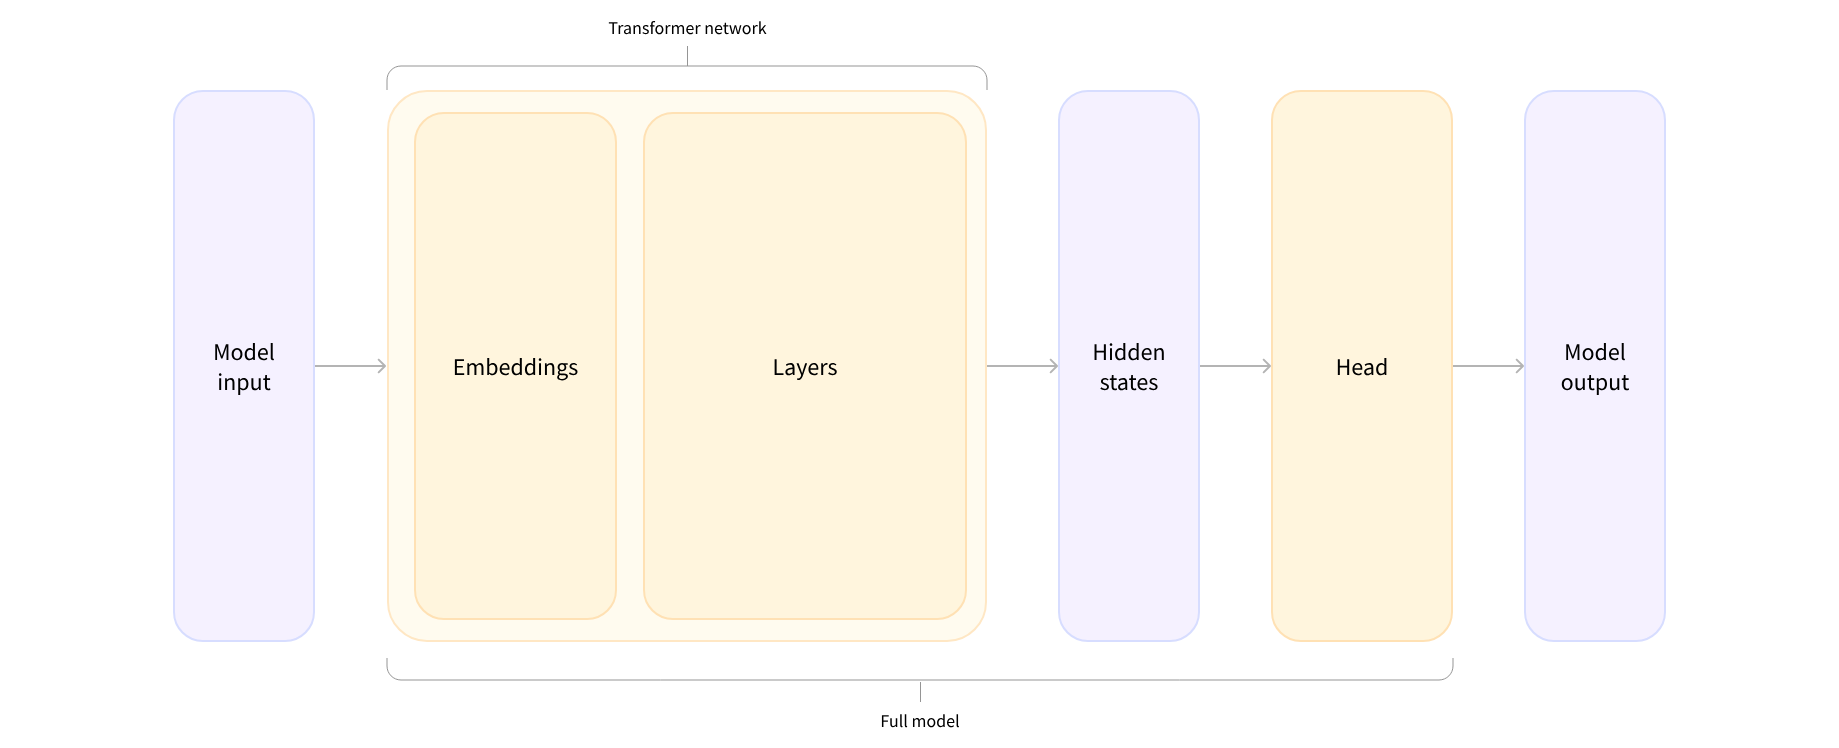

The output of the Transformer model is sent directly to the model head to be processed.

In this diagram, the model is represented by its embeddings layer and the subsequent layers. The embeddings layer converts each input ID in the tokenized input into a vector that represents the associated token. The subsequent layers manipulate those vectors using the attention mechanism to produce the final representation of the sentences.

There are many different architectures available in Hugging Face Transformers, with each one designed around tackling a specific task. Here is a non-exhaustive list:

- `*Model` (retrieve the hidden states)
- `*ForCausalLM`
- `*ForMaskedLM`
- `*ForMultipleChoice`
- `*ForQuestionAnswering`
- `*ForSequenceClassification`
- `*ForTokenClassification`
- and others

For our example, we will need a model with a sequence classification head (to be able to classify the sentences as positive or negative). So, we won’t actually use the `AutoModel` class, but `AutoModelForSequenceClassification`:

In [34]:
from transformers import AutoModelForSequenceClassification

In [35]:
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"

In [36]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)
# (batch_size, num_labels)
print(f"logits shape: {outputs.logits.shape}")

logits shape: torch.Size([3, 2])


Now if we look at the shape of our outputs, the dimensionality will be much lower: the model head takes as input the high-dimensional vectors we saw before, and outputs vectors containing two values (one per label). Since we have just two sentences and two labels, the result we get from our model is of shape 2x2.

# Postprocessing the output

The output contains the model's `logits`, the raw, unnormalized scores outputted by the last layer of the model. To be converted to probabilities, they need to go through a SoftMax layer (all HUgging Face Transformers models output the logits, as the loss function for training will generally fuse the last activation function, such as SoftMax, with the actual loss function, such as cross entropy):

In [37]:
import torch

In [38]:
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[3.5805e-04, 9.9964e-01],
        [2.5583e-04, 9.9974e-01],
        [9.9969e-01, 3.1303e-04]], grad_fn=<SoftmaxBackward0>)


We can see that the model predicted [0.0402, 0.9598] for the first sentence and [0.9995, 0.0005] for the second one. These are recognizable probability scores.

To get the labels corresponding to each position, we can inspect the id2label attribute of the model config (more on this in the next section):

In [39]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

In [43]:
for i, prediction in enumerate(predictions):
    text_case = raw_inputs[i]
    label = model.config.id2label[prediction.argmax().item()]
    score = prediction.max().item()
    print(f"Text: {text_case} - Predicted label: {label} - Score: {score:.4f}")

Text: I love going to the cinema. - Predicted label: POSITIVE - Score: 0.9996
Text: I am Mario! - Predicted label: POSITIVE - Score: 0.9997
Text: I hate this movie. - Predicted label: NEGATIVE - Score: 0.9997


------

We have successfully reproduced the three steps of the pipeline: preprocessing with tokenizers, passing the inputs through the model, and postprocessing!